In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from copy import deepcopy
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
import load_tracking
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
from tqdm import tqdm

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# prepare data

In [ ]:
try:
    dfs = pkl.load(open('/scratch/users/vision/chandan/abc/tracks_video.pkl', 'rb'))['dfs']
except:
    dsets = ['clath_aux+gak_a7d2', 'clath_aux+gak', 'clath_aux+gak_a7d2_new', 'clath_aux+gak_new', 'clath_gak']
    splits = ['train', 'test']
    #feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
                  #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
    meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
    dfs = {}
    length = 40
    for dset in tqdm(dsets):

        # load videos, only need to run once
        df = data.get_data(dset=dset, use_processed=False, video_data=True)

        # remove invalid tracks
        df = df[~(df.short | df.long | df.hotspots)]
        df = df[df.lifetime > 15]

        feat_names = ['X_video_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))

        # downsample tracks
        df['X_video_same_length'] = [features.downsample_video(df.iloc[i]['X_video'], length=length)
                                   for i in range(len(df))]
        # normalize tracks
        df = features.normalize_video(df, video='X_video_same_length')

        # regression response
        df = train_reg.add_sig_mean(df)  

        # normalize features
        for feat in feat_names:
            if 'video' not in feat and 'X_same_length' not in feat:
                df = features.normalize_feature(df, feat)
        for split in splits:
    #         df = df[df.valid]
    #         df = df[df.lifetime > 15] # only keep hard tracks

            dfs[(dset, split)] = deepcopy(df[df.cell_num.isin(config.DSETS[dset][split])]) # exclude held-out test data
    pkl.dump({'dfs': dfs}, open('/scratch/users/vision/chandan/abc/tracks_video.pkl', 'wb'))

In [11]:
# asssert each video is (40, 10, 10)
assert np.array([df['X_video_same_length_normalized'].iloc[i].shape == (40, 10, 10)
                 for i in range(len(df))]).all()

# show an example

In [118]:
ks = ['X_video_same_length_normalized', 'X', 'Y', 'Y_sig_mean_normalized', 'y_consec_sig']
df = pd.concat([dfs[(k, s)]
               for (k, s) in dfs
               if s == 'train' and k == 'clath_aux+gak_a7d2_new'])[ks]

# df_full = pd.concat([dfs[(k, s)]
#                for (k, s) in dfs
#                if s == 'train'])[ks]

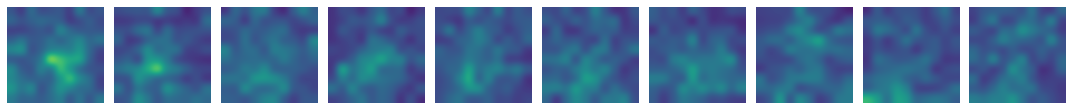

In [119]:
ex = df.iloc[0]
x = ex['X_video_same_length_normalized']

R, C = 1, 10
plt.figure(figsize=(15, 3))
vmin = x.min()
vmax = x.max()
for i in range(10):
    plt.subplot(R, C, i + 1)
    plt.imshow(x[i], vmin=vmin, vmax=vmax, interpolation='gaussian')
    plt.axis('off')

# fit the data

In [120]:
X = df[['X_video_same_length_normalized']] #.reshape(df_full.shape[0], 40, 10, 10)
y = df['Y_sig_mean_normalized'].values

In [121]:
X_train = X[:10000]
y_train = y[:10000]

In [122]:
dnn = neural_networks.neural_net_sklearn(track_name='X_video_same_length_normalized',
                                         arch='videonet',
                                         batch_size=2000,
                                         epochs=100)

In [ ]:
dnn.fit(X_train, y_train)




  0%|          | 0/100 [00:00<?, ?it/s]

fitting dnn...
